# 67818 Applied Competitive Lab in Data Science

## Final Project

### Participants:

- **Name:** Dan Badur
- **Student ID:** 209019256
- 
- **Name:** Tzur Breen
- **Student ID:** 209354919
- 
- **Name:** Shir Elbilia
- **Student ID:** 208621102
- 
- **Name:** Eliya Hasson
- **Student ID:** 208845032
- 
- **Name:** Tal Barda
- **Student ID:** 208729210

#### 1. Data Preparation and Feature Engineering:

We will start by loading data.csv into a pandas dataframe and then we will start by cleaning the data and removing any unnecessary columns.

In [53]:
import sns
from sklearn.neighbors import BallTree
import geopandas as gpd
import numpy as np
import concurrent.futures
import math
from distance_calculations import calculate_distances_chunk
from distance_calculations import find_nearest_area_codes
import os
import sqlite3
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


data_df = pd.read_csv("data.csv")
data_df = data_df.drop(columns=[
    'Unnamed: 0',
    'OBJECTID',
    'FOD_ID',
    'FPA_ID',
    'SOURCE_SYSTEM_TYPE',
    'SOURCE_SYSTEM',
    'NWCG_REPORTING_UNIT_ID',
    'NWCG_REPORTING_UNIT_NAME',
    'SOURCE_REPORTING_UNIT', 
    'SOURCE_REPORTING_UNIT_NAME',
    'LOCAL_FIRE_REPORT_ID',
    'LOCAL_INCIDENT_ID',
    'FIRE_CODE',
    'FIRE_NAME',
    'ICS_209_INCIDENT_NUMBER',
    'ICS_209_NAME', 
    'MTBS_ID',
    'MTBS_FIRE_NAME',
    'COMPLEX_NAME',
    'OWNER_CODE',
    'OWNER_DESCR',
    'FIPS_CODE',
    'FIPS_NAME',
    'Shape',
    'COUNTY',
    'FIRE_YEAR'
])

# Print the remaining columns
print(data_df.columns)

# Print null amount in each column
print(data_df.isnull().sum())

Index(['NWCG_REPORTING_AGENCY', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY',
       'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
       'STATE'],
      dtype='object')
NWCG_REPORTING_AGENCY         0
DISCOVERY_DATE                0
DISCOVERY_DOY                 0
DISCOVERY_TIME           256949
STAT_CAUSE_DESCR              0
CONT_DATE                265523
CONT_DOY                 265523
CONT_TIME                284611
FIRE_SIZE                     0
FIRE_SIZE_CLASS               0
LATITUDE                      0
LONGITUDE                     0
STATE                         0
dtype: int64


Now we will define a function for calculating the distance between each point in our database and a set of polygons in a wanted shapefile.
The function is set to run on multiple cors for better performance. 

For our original data containing 571000 rows for an 8 core CPU (the code utilizes 0.75 of the cores):
Calculating for the nature polygons takes about 3 minutes.
For the others it's about 30 seconds to 1 minute each.

In [54]:

total_cores = os.cpu_count()
cores_to_use = math.ceil(total_cores * 0.75)
num_cores = max(1, cores_to_use) 
WGS_84_GEO = "EPSG:4326"

def calculate_distances_gdf_to_polygon_parallel(points_gdf, polygons_gdf, target_name, attribute_name=None):

    num_chunks = num_cores * 4  
    points_chunks = np.array_split(points_gdf, num_chunks)  
    polygons_sindex = polygons_gdf.sindex
    
    with tqdm(total=len(points_chunks), desc="Processing chunks for "+target_name) as pbar:
        with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
            futures = [executor.submit(calculate_distances_chunk, chunk.geometry, polygons_gdf, polygons_sindex,return_attribute=attribute_name) for chunk in points_chunks]
            
            results = []
            for future in concurrent.futures.as_completed(futures):
                results.extend(future.result())
                pbar.update(1)
    
    return results

data_gdf = gpd.GeoDataFrame(data_df, geometry=gpd.points_from_xy(data_df.LONGITUDE, data_df.LATITUDE), crs=WGS_84_GEO)

nature_gdf = gpd.read_file('Nature/Nature.shp')
powerline_gdf = gpd.read_file('Powerline/Powerline.shp')
camp_gdf = gpd.read_file('Campgrounds/Campgrounds.shp')
population_gdf = gpd.read_file('Population/Population.shp')
railroads_gdf = gpd.read_file('Railroads/Railroads.shp')
schools_gdf = gpd.read_file('PublicSchools/PublicSchools.shp')
temp_gdf = gpd.read_file('Temperature/temps_shape.shp')

nature_gdf = nature_gdf.to_crs(WGS_84_GEO)
powerline_gdf = powerline_gdf.to_crs(WGS_84_GEO)
camp_gdf = camp_gdf.to_crs(WGS_84_GEO)
population_gdf = population_gdf.to_crs(WGS_84_GEO)
railroads_gdf = railroads_gdf.to_crs(WGS_84_GEO)
schools_gdf = schools_gdf.to_crs(WGS_84_GEO)
temp_gdf = temp_gdf.to_crs(WGS_84_GEO)

#Distance related features
data_df['distance_to_nearest_nature_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, nature_gdf, "Nature")
data_df['distance_to_nearest_powerline_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, powerline_gdf, "Powerline")
data_df['distance_to_nearest_campground_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, camp_gdf, "Campground")
data_df['distance_to_nearest_railroad_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, railroads_gdf, "Railroad")
data_df['distance_to_nearest_school_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, schools_gdf, "School")

distance_from_population_and_class = calculate_distances_gdf_to_polygon_parallel(data_gdf, population_gdf, "Population", "POP_CLASS")
data_df['distance_to_nearest_population'], data_df['nearest_population_class'] = zip(*distance_from_population_and_class)

/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future vers

For calculating the temperature related features we will use the BallTree algorithm to find the nearest temperature area codes for each fire.
Then we will find the nearest dates (or the date itself)s for each fire and use them to fetch the weather data from an SQLite database we created from the temperature data.

For unknown average temp we will use the average monthly temperature for the state and month of the fire.
For the rest of the unknown values we will use the mean of the column.

Fetching the weather data from the SQLite database takes about 20 minutes.


In [55]:
import os

temps_dfs_path = 'temps_dfs'
data_dict = {}
state_dict = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'DC': 'District of Columbia',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}


for year_dir in os.listdir(temps_dfs_path):
    year_path = os.path.join(temps_dfs_path, year_dir)
    
    if os.path.isdir(year_path):
        year_dict = {}
        
        for month_dir in os.listdir(year_path):
            month_path = os.path.join(year_path, month_dir)
            
            if os.path.isdir(month_path):
                days_list = [day.split('.')[0] for day in os.listdir(month_path) if day.endswith('.csv')]
                
                year_dict[int(month_dir)] = sorted(map(int, days_list))
        
        data_dict[int(year_dir)] = year_dict

coords_shapefile = np.array(list(temp_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
tree = BallTree(coords_shapefile, leaf_size=2)

tqdm.pandas(desc="Finding nearest temperature area codes")

column_nearest_area_codes = 'nearest_area_codes'
column_nearest_dates = 'nearest_dates'

data_df[column_nearest_area_codes] = data_gdf.progress_apply(find_nearest_area_codes, tree=tree, gdf_points=temp_gdf, axis=1)

column_discovery_date_temp = 'DISCOVERY_DATE_TEMP'
data_df[column_discovery_date_temp] = pd.to_datetime(data_df['DISCOVERY_DATE'], origin='julian', unit='D')
data_df['FIRE_YEAR'] = data_df[column_discovery_date_temp].dt.year
data_df['Month'] = data_df[column_discovery_date_temp].dt.month
data_df['Day'] = data_df[column_discovery_date_temp].dt.day

def get_nearest_dates(row):
    year = row['FIRE_YEAR']
    month = row['Month']
    day = row['Day']
    nearest_dates = []
    
    if year in data_dict:
        if month in data_dict[year]:
            nearest_month = month
        else:
            nearest_month = min(data_dict[year].keys(), key=lambda x: abs(x - month))
        
        nearest_days = sorted(data_dict[year][nearest_month], key=lambda x: abs(x - day))[:10]
        
        for nearest_day in nearest_days:
            nearest_dates.append(f"{year}/{nearest_month:02d}/{nearest_day:02d}")
    
    return nearest_dates

tqdm.pandas(desc="Finding nearest dates for each fire data")
data_df[column_nearest_dates] = data_df.progress_apply(get_nearest_dates, axis=1)

conn_area_codes = sqlite3.connect('temps_area_code_dates.db')
conn_monthly = sqlite3.connect('average_monthly_temperature_by_state_1950-2022.db')

def get_monthly_mean(row):
    query = f'''
        SELECT average_temp
        FROM monthly_data
        WHERE year = {row['FIRE_YEAR']} AND month = {row['Month']} AND state = '{state_dict[row['STATE']]}'
        LIMIT 1
    '''
    cursor = conn_monthly.cursor()
    cursor.execute(query)
    result = cursor.fetchone()
    cursor.close()
    return result[0] if result else None


def get_weather_data(row):
    nearest_dates = row[column_nearest_dates]  # Get the nearest dates list
    area_codes = [int(x) for x in row[column_nearest_area_codes]]

    max_temp, min_temp, prcp, avg_temp = None, None, None, None
    
    for nearest_date in nearest_dates:
        for area_code in area_codes:
            query = f'''
                SELECT max_temp, min_temp, prcp, avg_temp
                FROM weather_data
                WHERE YEAR = {nearest_date.split('/')[0]}
                AND MONTH = {nearest_date.split('/')[1]}
                AND DAY = {nearest_date.split('/')[2]}
                AND area_code = {area_code}
                LIMIT 1
            '''

            cursor = conn_area_codes.cursor()
            cursor.execute(query)
            result = cursor.fetchone()
            cursor.close()

            if result:
                max_temp = result[0] if max_temp is None and result[0] is not None else max_temp
                min_temp = result[1] if min_temp is None and result[1] is not None else min_temp
                prcp = result[2] if prcp is None and result[2] is not None else prcp
                avg_temp = result[3] if avg_temp is None and result[3] is not None else avg_temp
                
                if all([max_temp, min_temp, prcp, avg_temp]):
                    break

        if all([max_temp, min_temp, prcp, avg_temp]):
            break
    
    if min_temp is None or max_temp is None or avg_temp is None:
        monthly_mean = get_monthly_mean(row)
        if monthly_mean is not None:
            if avg_temp is None:
                avg_temp = monthly_mean

    return max_temp, min_temp, prcp, avg_temp


progress_bar = tqdm(total=len(data_df), desc="Fetching weather data from SQLite Database")

for index, row in data_df.iterrows():
    max_temp, min_temp, prcp, avg_temp = get_weather_data(row)
    progress_bar.update(1)  # Update progress for each row fetched
    
    data_df.at[index, 'MAX_TEMP'] = max_temp
    data_df.at[index, 'MIN_TEMP'] = min_temp
    data_df.at[index, 'PRCP'] = prcp
    data_df.at[index, 'AVG_TEMP'] = avg_temp

conn_area_codes.close()
conn_monthly.close()

#Remove the columns we used for the calculations
data_df = \
    (data_df.drop( 
        columns=[
            column_nearest_area_codes,
            column_nearest_dates,
            'STATE',
            column_discovery_date_temp]))

Fetching weather data from SQLite Database: 100%|█████████▉| 571413/571425 [14:25<00:00, 716.33it/s]

Next we will explore time related features.

We worked on adding and exploring features related to time. We decided to check whether there is a connection between holidays and the type of the cause of the fire. The rational was that during holidays and vacations, people are returning home and may have more time to travel (campfire) or they just get bored and do some stupid things (children, arson...). Therefore, we downloaded a dataset that contains the dates of some holidays in the USA and added to our dataset the distance of every fire from the closest holiday in days. The added features are "nearest_holiday", "days_from_closest_holiday".

In [56]:
from datetime import datetime, timedelta

holiday_dates_df = pd.read_csv(f"US Holiday Dates (1992-2015).csv")

holiday_dates_df['Date'] = pd.to_datetime(holiday_dates_df['Date'], dayfirst=True, format="%d/%m/%Y")

holiday_dict = {}
for year in holiday_dates_df['Year'].unique():
    holiday_dict[year] = holiday_dates_df[holiday_dates_df['Year'] == year]

def find_nearest_holiday(fire_year, discovery_doy):
    if fire_year not in holiday_dict:
        return ("No Data", "No Data")
    year_holidays = holiday_dict[fire_year]
    fire_date = datetime(fire_year, 1, 1) + timedelta(days=discovery_doy - 1)
    nearest_holiday = None
    min_days_diff = float('inf')
    for _, row in year_holidays.iterrows():
        holiday_date = row['Date']
        diff = abs((fire_date - holiday_date).days)
        if diff < min_days_diff:
            min_days_diff = diff
            nearest_holiday = row['Holiday']
    return (nearest_holiday, min_days_diff)

tqdm.pandas(desc="Finding nearest holiday for each fire")
data_df['nearest_holiday'], data_df['days_from_closest_holiday'] = zip(*data_df.progress_apply(lambda row: find_nearest_holiday(row['FIRE_YEAR'], row['DISCOVERY_DOY']), axis=1))

#encoding the holiday feature
ohe = OneHotEncoder(sparse_output=False)
encoded_holiday = ohe.fit_transform(data_df[['nearest_holiday']])
data_df = pd.concat([data_df.drop(columns=['nearest_holiday']), pd.DataFrame(encoded_holiday, columns=ohe.get_feature_names_out())], axis=1)



Finding nearest holiday for each fire: 100%|██████████| 571425/571425 [03:56<00:00, 2415.17it/s]


We will also add here a season feature that will help predict the cause type:

In [57]:

def get_season(month):
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3
    
data_df['Season'] = data_df['Month'].apply(get_season)

We continue by making a new feature to check for the time it took to contain the fire using the DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE and CONT_TIME, for unknown CONT_TIME we will take the mean of the newly made TIME_TO_CONT_MINUTES feature (will be calculated using only train set to avoid data leakage)

In [58]:

def convert_datetime(df, date_column, time_column, datetime_column):
    df[date_column] = pd.to_datetime(df[date_column], unit='D', origin='julian')

    mask = df[time_column].notna()  
    hours = df.loc[mask, time_column] // 100
    minutes = df.loc[mask, time_column] % 100

    time_timedelta = pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')

    df.loc[mask, datetime_column] = df.loc[mask, date_column] + time_timedelta
    
convert_datetime(data_df, 'DISCOVERY_DATE', 'DISCOVERY_TIME', 'DISCOVERY_DATETIME')
convert_datetime(data_df, 'CONT_DATE', 'CONT_TIME', 'CONT_DATETIME')

data_df['TIME_TO_CONT_MINUTES'] = (data_df['CONT_DATETIME'] - data_df['DISCOVERY_DATETIME']).dt.total_seconds() / 60
data_df.drop(["CONT_DATETIME", "DISCOVERY_DATETIME"], axis=1, inplace=True)

Next, we continue by encoding the categorical feature "NWCG_REPORTING_AGENCY" to one-hot encoding. We chose to encode this feature using one-hot encoding since we have a large number of agencies while some of them have sparse samples of data.

In [59]:

ohe = OneHotEncoder(sparse_output=False)  
encoded_data = ohe.fit_transform(data_df[['NWCG_REPORTING_AGENCY']])

df_encoded = pd.concat([data_df.drop(columns=['NWCG_REPORTING_AGENCY']), pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out())], axis=1)

We will also encode FIRE_CLASS:

In [60]:
fire_class_ohe = OneHotEncoder(sparse_output=False)
fire_class_encoded = fire_class_ohe.fit_transform(df_encoded[['FIRE_SIZE_CLASS']])
df_encoded = pd.concat([df_encoded.drop(columns=['FIRE_SIZE_CLASS']), pd.DataFrame(fire_class_encoded, columns=fire_class_ohe.get_feature_names_out())], axis=1)

Lastly, before splitting the data into train and test sets, we will remove the columns we used to build the new features and encode the target column "STAT_CAUSE_DESCR" to integers:

In [61]:

from sklearn.model_selection import train_test_split

# Remove the rest of the columns we don't need:
df_encoded = df_encoded.drop(
    columns=[
        'DISCOVERY_DATE',
        'DISCOVERY_TIME',
        'CONT_DATE',
        'CONT_TIME',
        'CONT_DOY',
        'FIRE_YEAR',
        'Month', 
        'Day', 
        ])


# Change the target column to the last column:
target_column = df_encoded.pop('STAT_CAUSE_DESCR')
df_encoded['STAT_CAUSE_DESCR'] = target_column

# Make the target column integer:
category_mapping = df_encoded['STAT_CAUSE_DESCR'].astype('category')
mapping_dict = dict(enumerate(category_mapping.cat.categories))
df_encoded['STAT_CAUSE_DESCR'] = category_mapping.cat.codes

#export the df_encoded to a csv file
df_encoded.to_csv('df_encoded.csv', index=False)

Now we are ready to split the data into train and test sets and fill the missing values in the train set with the mean of the column (in the train set) and apply the same values to the test set (to avoid data leakage).

In [62]:

train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

#calculate the mean of none values in the train set:
mean_time_to_cont = train_df['TIME_TO_CONT_MINUTES'].mean()
mean_max_temp = train_df['MAX_TEMP'].mean()
mean_min_temp = train_df['MIN_TEMP'].mean()
mean_prcp = train_df['PRCP'].mean()
mean_avg_temp = train_df['AVG_TEMP'].mean()
mean_fire_size = train_df['FIRE_SIZE'].mean()

#apply to train and test:
train_df['TIME_TO_CONT_MINUTES'] = train_df['TIME_TO_CONT_MINUTES'].fillna(mean_time_to_cont)
train_df['MAX_TEMP'] = train_df['MAX_TEMP'].fillna(mean_max_temp)
train_df['MIN_TEMP'] = train_df['MIN_TEMP'].fillna(mean_min_temp)
train_df['PRCP'] = train_df['PRCP'].fillna(mean_min_temp)
train_df['AVG_TEMP']= train_df['AVG_TEMP'].fillna(mean_avg_temp)
train_df['FIRE_SIZE'] = train_df['FIRE_SIZE'].fillna(mean_fire_size)

test_df['TIME_TO_CONT_MINUTES'] = test_df['TIME_TO_CONT_MINUTES'].fillna(mean_time_to_cont)
test_df['MAX_TEMP'] = test_df['MAX_TEMP'].fillna(mean_max_temp)
test_df['MIN_TEMP'] = test_df['MIN_TEMP'].fillna(mean_min_temp)
test_df['PRCP'] = test_df['PRCP'].fillna(mean_prcp)
test_df['AVG_TEMP']= test_df['AVG_TEMP'].fillna(mean_avg_temp)
test_df['FIRE_SIZE'] = test_df['FIRE_SIZE'].fillna(mean_fire_size)

We will start with a baseline model using a simple K-Nearest Neighbors Classifier and evaluate it using the test set via ROC AUC score and accuracy.

In [63]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

X_train = train_df.drop(columns=['STAT_CAUSE_DESCR'])
y_train = train_df['STAT_CAUSE_DESCR']

X_test = test_df.drop(columns=['STAT_CAUSE_DESCR'])
y_test = test_df['STAT_CAUSE_DESCR']

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_prob = knn.predict_proba(X_test)

knn_score = roc_auc_score(y_test, knn_prob, multi_class='ovr')
print(f"K-Nearest Neighbors Classifier ROC AUC score: {knn_score:.2f}\n")

knn_predictions = knn.predict(X_test)
print(classification_report(y_test, knn_predictions, target_names=list(mapping_dict.values())))

K-Nearest Neighbors Classifier ROC AUC score: 0.67
                precision    recall  f1-score   support

         Arson       0.31      0.43      0.36     18506
      Campfire       0.27      0.21      0.23      5067
      Children       0.17      0.12      0.14      4095
Debris Burning       0.42      0.54      0.47     28523
 Equipment Use       0.27      0.18      0.22      9984
     Fireworks       0.48      0.35      0.40       781
     Lightning       0.68      0.75      0.71     18573
 Miscellaneous       0.40      0.31      0.35     21742
     Powerline       0.18      0.02      0.04       974
      Railroad       0.32      0.12      0.18      2230
       Smoking       0.08      0.01      0.02      3568
     Structure       0.05      0.00      0.01       242

      accuracy                           0.42    114285
     macro avg       0.30      0.25      0.26    114285
  weighted avg       0.40      0.42      0.40    114285


Next we will check another baseline model using a simple Random Forest Classifier and evaluate it using the test set via ROC AUC score and accuracy.

In [64]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)

rfc_prob = rfc.predict_proba(X_test)
rfc_score = roc_auc_score(y_test, rfc_prob, multi_class='ovr')
print(f"Random Forest Classifier ROC AUC score: {rfc_score:.2f}\n")

rfc_predictions = rfc.predict(X_test)
print(classification_report(y_test, rfc_predictions, target_names=list(mapping_dict.values())))

Random Forest Classifier ROC AUC score: 0.73
                precision    recall  f1-score   support

         Arson       0.40      0.47      0.43     18506
      Campfire       0.41      0.28      0.33      5067
      Children       0.24      0.13      0.17      4095
Debris Burning       0.46      0.62      0.53     28523
 Equipment Use       0.32      0.21      0.25      9984
     Fireworks       0.59      0.38      0.46       781
     Lightning       0.75      0.81      0.78     18573
 Miscellaneous       0.45      0.41      0.43     21742
     Powerline       0.10      0.01      0.01       974
      Railroad       0.44      0.20      0.28      2230
       Smoking       0.17      0.02      0.03      3568
     Structure       0.30      0.03      0.05       242

      accuracy                           0.48    114285
     macro avg       0.39      0.30      0.31    114285
  weighted avg       0.46      0.48      0.46    114285



Now we will train Gradeint Boosting Classifier and Random Forest Classifier models and evaluate them using the test set via ROC AUC score and accuracy.

In [65]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


df_encoded = df_encoded.drop(columns=df_encoded.columns[df_encoded.columns.str.startswith('NWGC')])
df_encoded = df_encoded.drop(columns=df_encoded.columns[df_encoded.columns.str.startswith('nearest_holiday')])

X_train = train_df.drop(columns=['STAT_CAUSE_DESCR'])
y_train = train_df['STAT_CAUSE_DESCR']

X_test = test_df.drop(columns=['STAT_CAUSE_DESCR'])
y_test = test_df['STAT_CAUSE_DESCR']

gbc = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=1,
    random_state=42,
    verbose=1)

gbc.fit(X_train, y_train)

gbc_prob = gbc.predict_proba(X_test)
gbc_score = roc_auc_score(y_test, gbc_prob, multi_class='ovr')
gbc_predictions = gbc.predict(X_test)
print(f"Gradient Boosting Classifier ROC AUC score: {gbc_score:.2f}")
print(classification_report(y_test, gbc_predictions, target_names=list(mapping_dict.values())))

rfc = RandomForestClassifier(
    n_estimators=100,
    random_state=42, 
    verbose=1)

rfc.fit(X_train, y_train)

rfc_prob = rfc.predict_proba(X_test)
rfc_score = roc_auc_score(y_test, rfc_prob, multi_class='ovr')
print(f"Random Forest Classifier ROC AUC score: {rfc_score:.2f}")
rfc_predictions = rfc.predict(X_test)
print(classification_report(y_test, rfc_predictions, target_names=list(mapping_dict.values())))


      Iter       Train Loss   Remaining Time 
         1           1.9499           12.03m
         2           1.9165           12.13m
         3           1.8917           11.91m
         4           1.8689           11.75m
         5           1.8510           11.73m
         6           1.8338           11.63m
         7           1.8207           11.58m
         8           1.8081           11.41m
         9           1.7969           11.28m
        10           1.7878           11.18m
        20           1.7198            9.83m
        30           1.6817            8.57m
        40           1.6542            7.32m
        50           1.6352            6.08m
        60           1.6201            4.84m
        70           1.6076            3.62m
        80           1.5975            2.41m
        90           1.5884            1.20m
       100           1.5806            0.00s
Gradient Boosting Classifier ROC AUC score: 0.78
                precision    recall  f1-score   su

/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Random Forest Classifier ROC AUC score: 0.82


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s


                precision    recall  f1-score   support

         Arson       0.51      0.43      0.47     18506
      Campfire       0.55      0.27      0.37      5067
      Children       0.39      0.11      0.18      4095
Debris Burning       0.48      0.74      0.58     28523
 Equipment Use       0.42      0.19      0.26      9984
     Fireworks       0.63      0.45      0.52       781
     Lightning       0.74      0.85      0.79     18573
 Miscellaneous       0.47      0.49      0.48     21742
     Powerline       0.39      0.01      0.03       974
      Railroad       0.47      0.29      0.35      2230
       Smoking       0.26      0.01      0.02      3568
     Structure       0.56      0.04      0.08       242

      accuracy                           0.53    114285
     macro avg       0.49      0.32      0.34    114285
  weighted avg       0.51      0.53      0.50    114285


We will now evaluate the models using K-Fold cross-validation and compare the results.

In [66]:
from sklearn.model_selection import cross_val_score

gbc_cv_scores = cross_val_score(gbc, X_train, y_train, cv=5, scoring='roc_auc_ovr')
print(f"Gradient Boosting Classifier Cross-Validation ROC AUC scores: {gbc_cv_scores}")
print(f"Gradient Boosting Classifier Cross-Validation ROC AUC mean score: {gbc_cv_scores.mean():.2f}\n")

rfc_cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc_ovr')
print(f"Random Forest Classifier Cross-Validation ROC AUC scores: {rfc_cv_scores}")
print(f"Random Forest Classifier Cross-Validation ROC AUC mean score: {rfc_cv_scores.mean():.2f}\n")

if gbc_cv_scores.mean() > rfc_cv_scores.mean():
    better_model = gbc
    better_model_name = "GBC"
    print("Gradient Boosting Classifier is better")
else:
    better_model = rfc
    better_model_name = "RFC"
    print("Random Forest Classifier is better")

      Iter       Train Loss   Remaining Time 
         1           1.9499            9.16m
         2           1.9165            9.04m
         3           1.8917            9.00m
         4           1.8688            8.95m
         5           1.8512            8.86m
         6           1.8342            8.77m
         7           1.8206            8.66m
         8           1.8081            8.55m
         9           1.7971            8.45m
        10           1.7876            8.36m
        20           1.7205            7.40m
        30           1.6814            6.48m
        40           1.6549            5.57m
        50           1.6352            4.65m
        60           1.6196            3.75m
        70           1.6075            2.81m
        80           1.5971            1.88m
        90           1.5881           56.19s
       100           1.5801            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.9497            9.04m
        

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   48.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s


Random Forest Classifier Cross-Validation ROC AUC scores: [0.81479749 0.81727976 0.81594651 0.81754618 0.8191238 ]
Random Forest Classifier Cross-Validation ROC AUC mean score: 0.82

Random Forest Classifier is better


Next we will look upon the confusion matrix of the better model:

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s


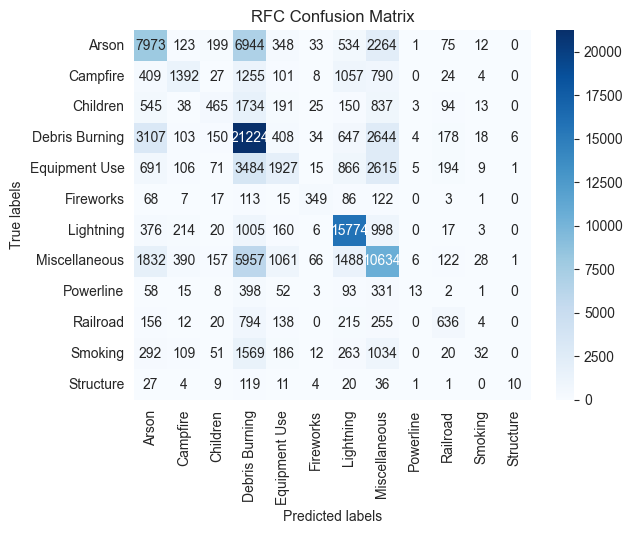

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


better_model_predictions = better_model.predict(X_test)
better_model_predictions_strings = [mapping_dict[label] for label in better_model_predictions]
y_test_strings = [mapping_dict[label] for label in y_test]  # Convert y_test to strings

labels_list = list(mapping_dict.values())
better_model_cm = confusion_matrix(y_test_strings, better_model_predictions_strings, labels=labels_list)

sns.heatmap(better_model_cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(better_model_name+' Confusion Matrix')
plt.show()

Now we will check for each fire type the two most confusing types for the better model (not including itself).
We will calculate the percentage of the total amount of fires that were classified as the confusing type.

In [68]:
better_model_cm = confusion_matrix(y_test_strings, better_model_predictions_strings, labels=labels_list)

for i, row in enumerate(better_model_cm):
    print(f"Most confusing types for {labels_list[i]}:")
    for j in row.argsort()[-3:][::-1]:
        if j != i:
            print(f"{labels_list[j]}: {row[j] / row.sum() * 100:.2f}%")
    print()


Most confusing types for Arson:
Debris Burning: 37.52%
Miscellaneous: 12.23%

Most confusing types for Campfire:
Debris Burning: 24.77%
Lightning: 20.86%

Most confusing types for Children:
Debris Burning: 42.34%
Miscellaneous: 20.44%
Arson: 13.31%

Most confusing types for Debris Burning:
Arson: 10.89%
Miscellaneous: 9.27%

Most confusing types for Equipment Use:
Debris Burning: 34.90%
Miscellaneous: 26.19%

Most confusing types for Fireworks:
Miscellaneous: 15.62%
Debris Burning: 14.47%

Most confusing types for Lightning:
Debris Burning: 5.41%
Miscellaneous: 5.37%

Most confusing types for Miscellaneous:
Debris Burning: 27.40%
Arson: 8.43%

Most confusing types for Powerline:
Debris Burning: 40.86%
Miscellaneous: 33.98%
Lightning: 9.55%

Most confusing types for Railroad:
Debris Burning: 35.61%
Miscellaneous: 11.43%

Most confusing types for Smoking:
Debris Burning: 43.97%
Miscellaneous: 28.98%
Arson: 8.18%

Most confusing types for Structure:
Debris Burning: 49.17%
Miscellaneous: 1

Seeing that data imbalance is a problem, we will now balance the data using Oversampling, Under sampling and SMOTE and check if it improves the better model.

In [69]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

better_model.fit(X_train_ros, y_train_ros)
better_model_predictions_ros = better_model.predict_proba(X_test)

ros_score = roc_auc_score(y_test, better_model_predictions_ros, multi_class='ovr')
print(f"Random Over Sampler ROC AUC score: {ros_score:.2f}")

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

better_model.fit(X_train_rus, y_train_rus)
better_model_predictions_rus = better_model.predict_proba(X_test)

rus_score = roc_auc_score(y_test, better_model_predictions_rus, multi_class='ovr')
print(f"Random Under Sampler ROC AUC score: {rus_score:.2f}")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

better_model.fit(X_train_smote, y_train_smote)
better_model_predictions_smote = better_model.predict_proba(X_test)

smote_score = roc_auc_score(y_test, better_model_predictions_smote, multi_class='ovr')
print(f"SMOTE ROC AUC score: {smote_score:.2f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s


Random Over Sampler ROC AUC score: 0.83


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


Random Under Sampler ROC AUC score: 0.79


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  4.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.6s


SMOTE ROC AUC score: 0.83


Seeing that the improvement is not significant, we will now try optimizing the hyperparameters of the better model using Optuna:

In [70]:

import optuna

if better_model_name == 'GBC':
    print("Gradient Boosting Classifier is being optimized")
else:
    print("Random Forest Classifier is being optimized")

def objective(trial):
    if better_model_name == 'GBC':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2)
        }
        model = GradientBoostingClassifier(**param)
    else:
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        }
        model = RandomForestClassifier(**param)

    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc_ovr').mean()
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best parameters for {better_model}: {study.best_params}")
print(f"Best cross-validation ROC AUC score: {study.best_value}")


[I 2024-04-10 17:57:14,095] A new study created in memory with name: no-name-8cf1f373-4b1d-4129-81e2-42adb73e1a7e


Random Forest Classifier is being optimized


[I 2024-04-10 17:58:53,316] Trial 0 finished with value: 0.760962323580027 and parameters: {'n_estimators': 154, 'max_depth': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.760962323580027.
[I 2024-04-11 10:32:42,973] Trial 1 finished with value: 0.8057770167015722 and parameters: {'n_estimators': 270, 'max_depth': 10, 'max_features': None}. Best is trial 1 with value: 0.8057770167015722.
[I 2024-04-11 10:34:56,009] Trial 2 finished with value: 0.7581752005155807 and parameters: {'n_estimators': 267, 'max_depth': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.8057770167015722.
[I 2024-04-11 11:01:33,105] Trial 3 finished with value: 0.7663062181838249 and parameters: {'n_estimators': 287, 'max_depth': 7, 'max_features': None}. Best is trial 1 with value: 0.8057770167015722.
[I 2024-04-11 11:05:19,632] Trial 4 finished with value: 0.6380048586827783 and parameters: {'n_estimators': 136, 'max_depth': 2, 'max_features': None}. Best is trial 1 with value: 0.8057770167

Best parameters for RandomForestClassifier(random_state=42, verbose=1): {'n_estimators': 242, 'max_depth': 10, 'max_features': None}
Best cross-validation ROC AUC score: 0.8064362793597817


Now we will use the better model with the optimized hyperparameters:

In [71]:
if better_model_name == 'GBC':
    better_model = GradientBoostingClassifier(**study.best_params)
else:
    better_model = RandomForestClassifier(**study.best_params)

We will now check the feature importance of the better model:

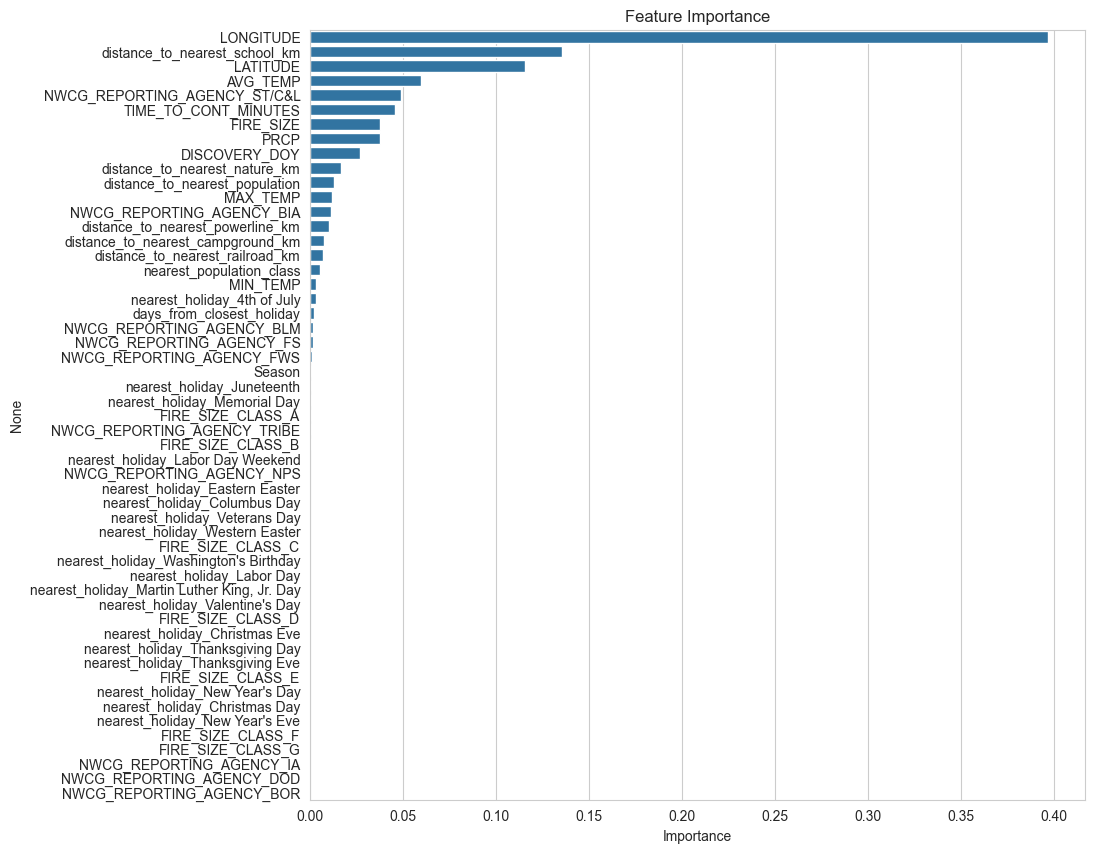

In [72]:

better_model.fit(X_train, y_train)

feature_importance = better_model.feature_importances_
feature_importance_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df.index)
plt.title('Feature Importance')
plt.show()

Next, we will try using feature permutation to check the feature importance:

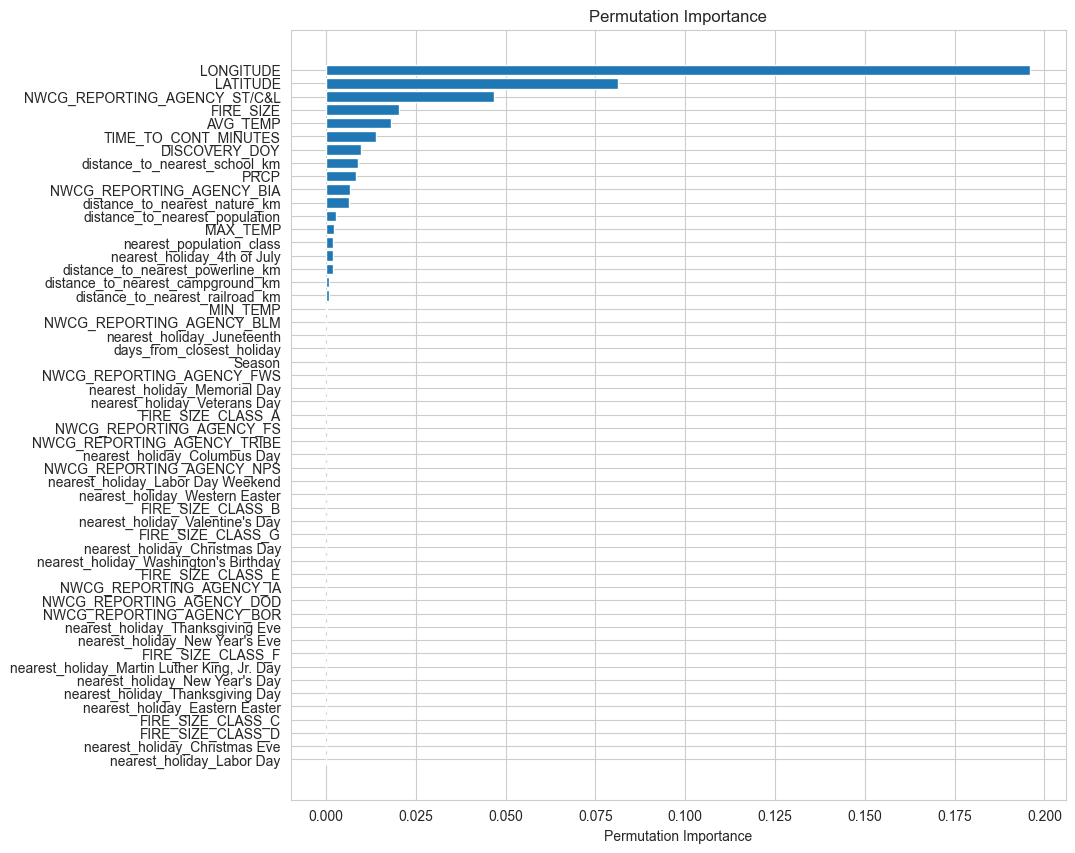

In [73]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(better_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 10))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance")
plt.show()

To get better insight into the feature importance, we will train a model for each cause and plot the feature importance's for each model:

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 11.5min


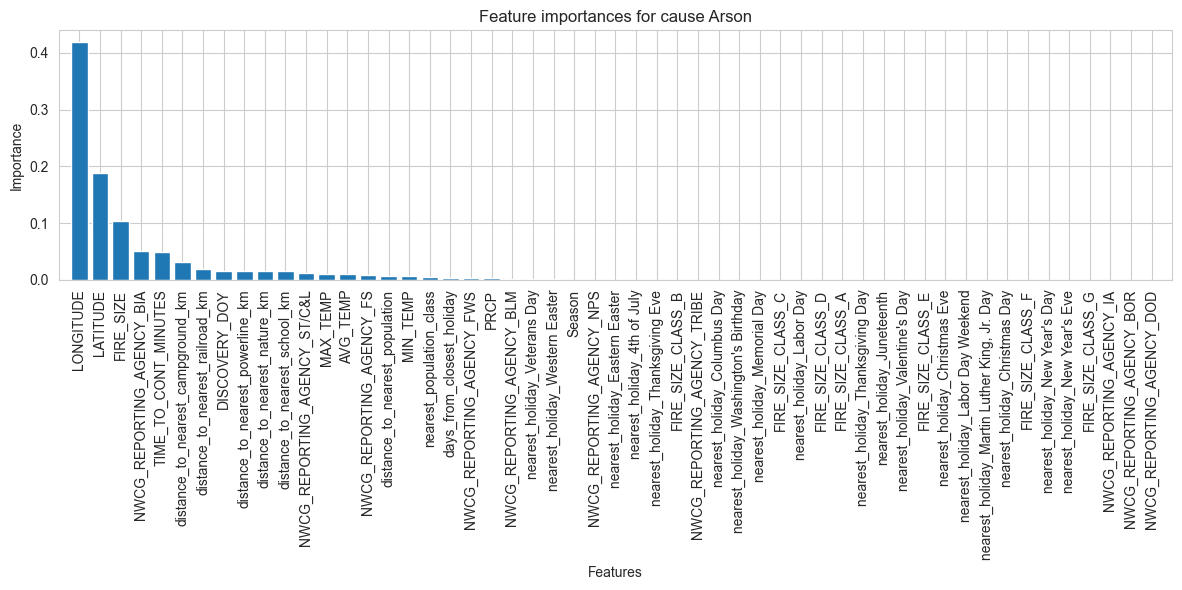

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.4min


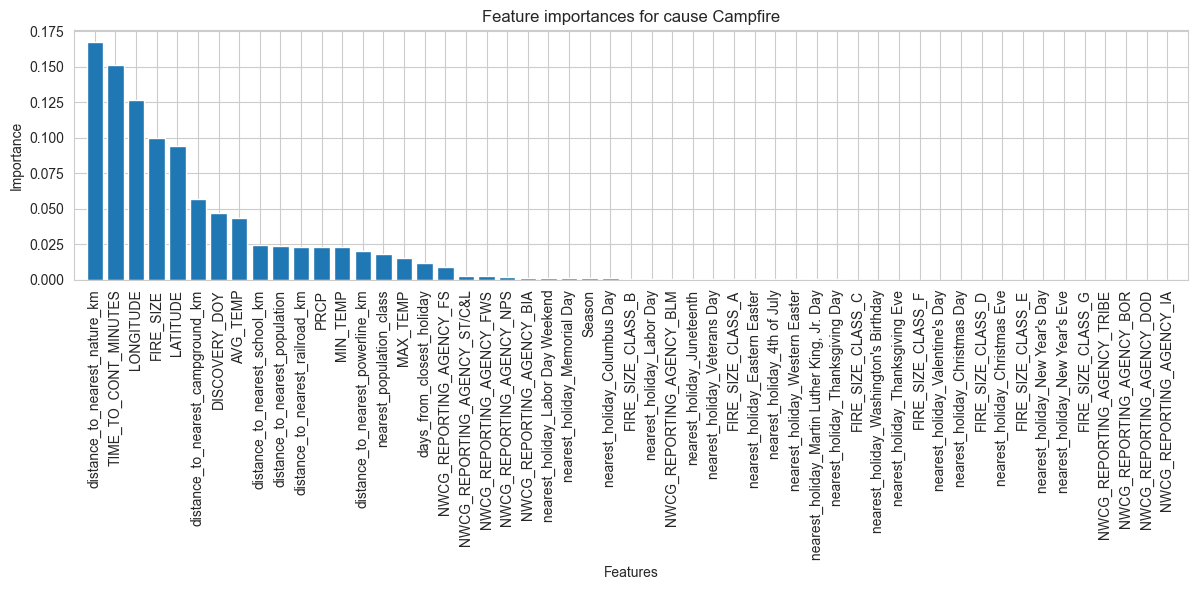

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.4min


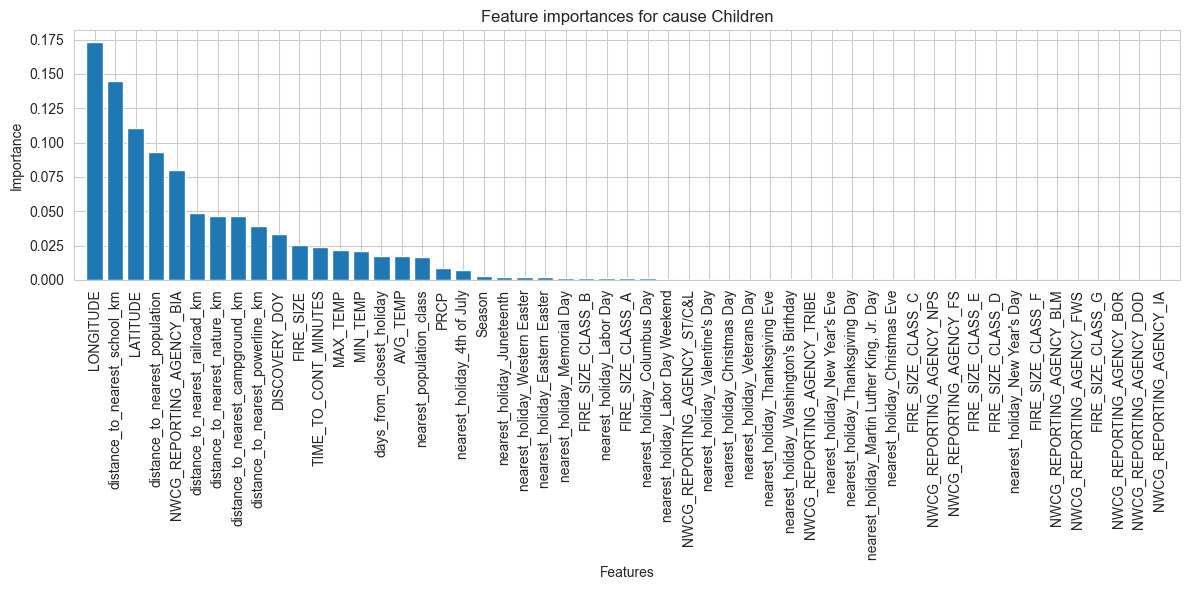

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.4min


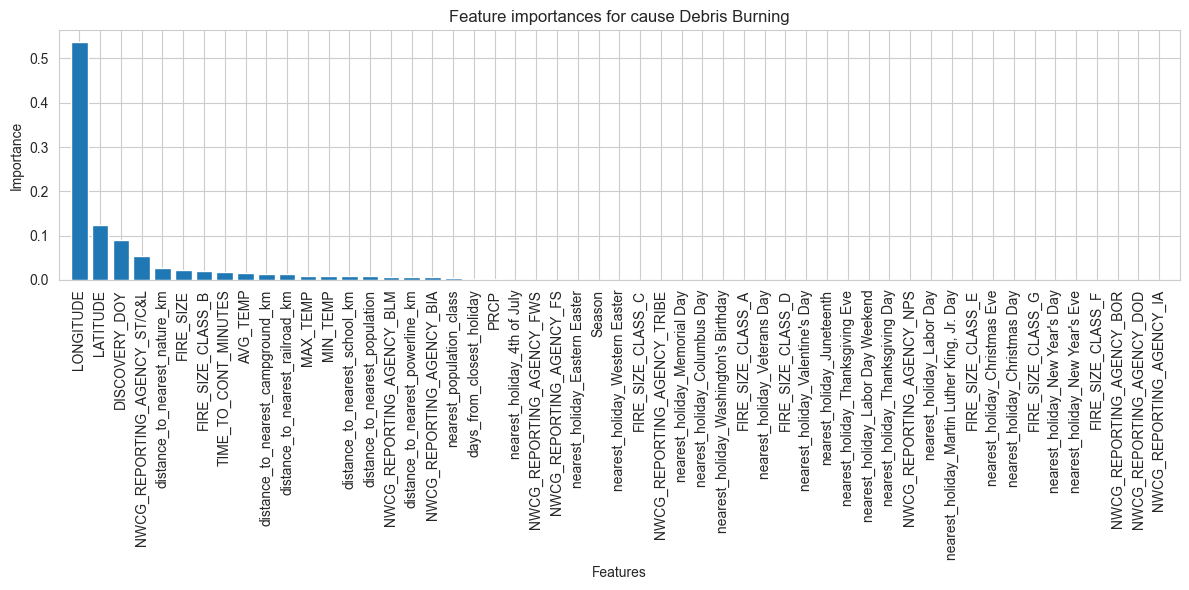

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 11.9min


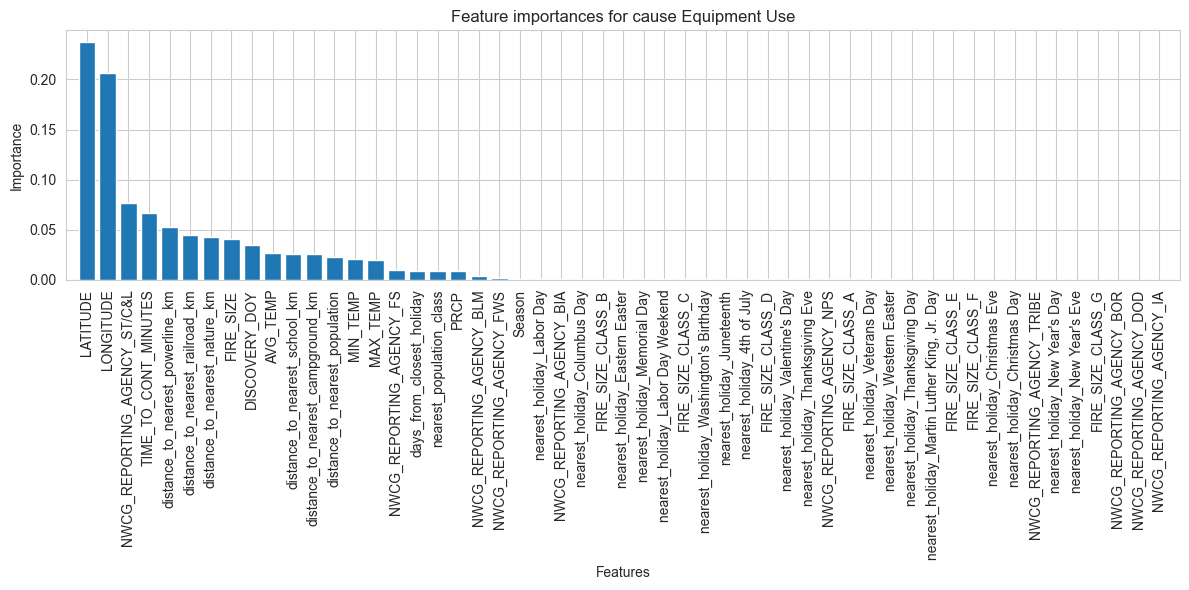

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.8min


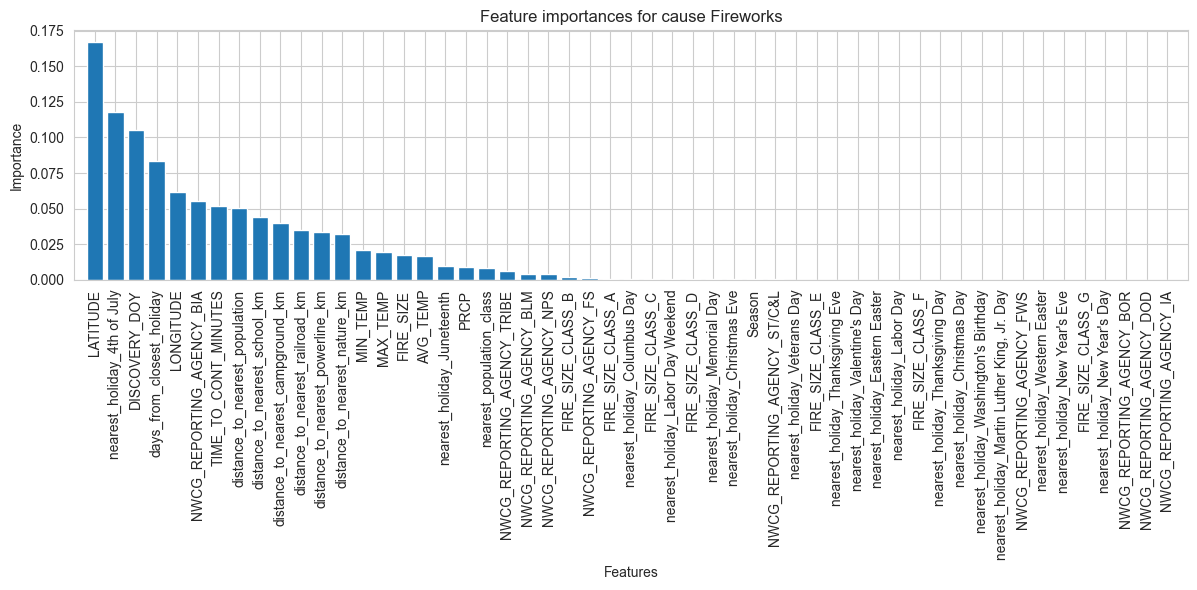

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.2min


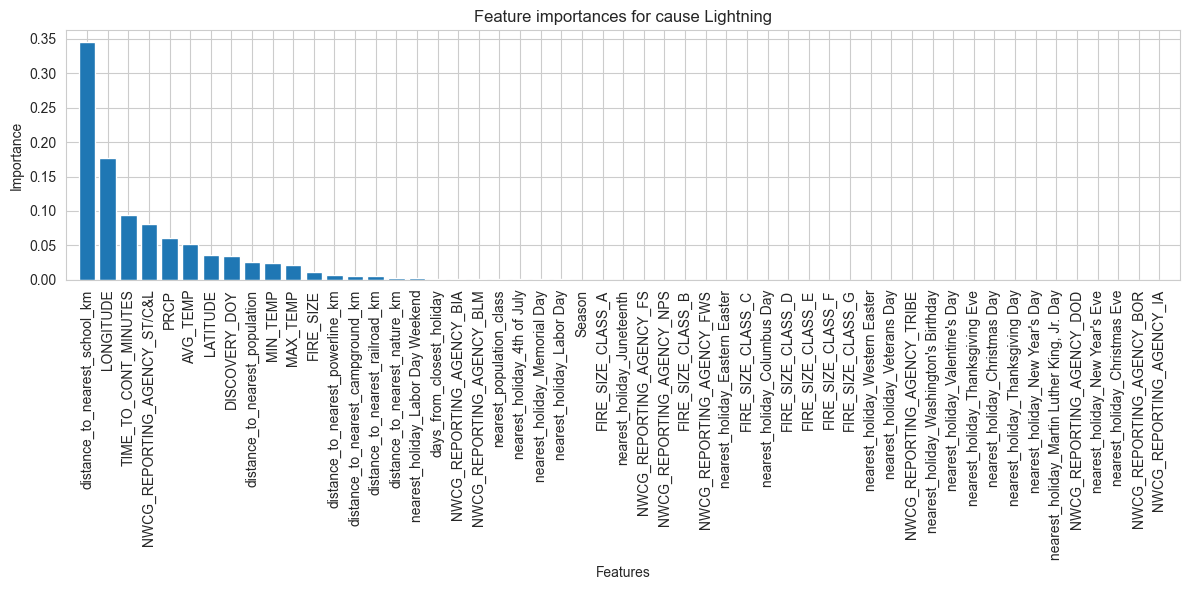

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 11.9min


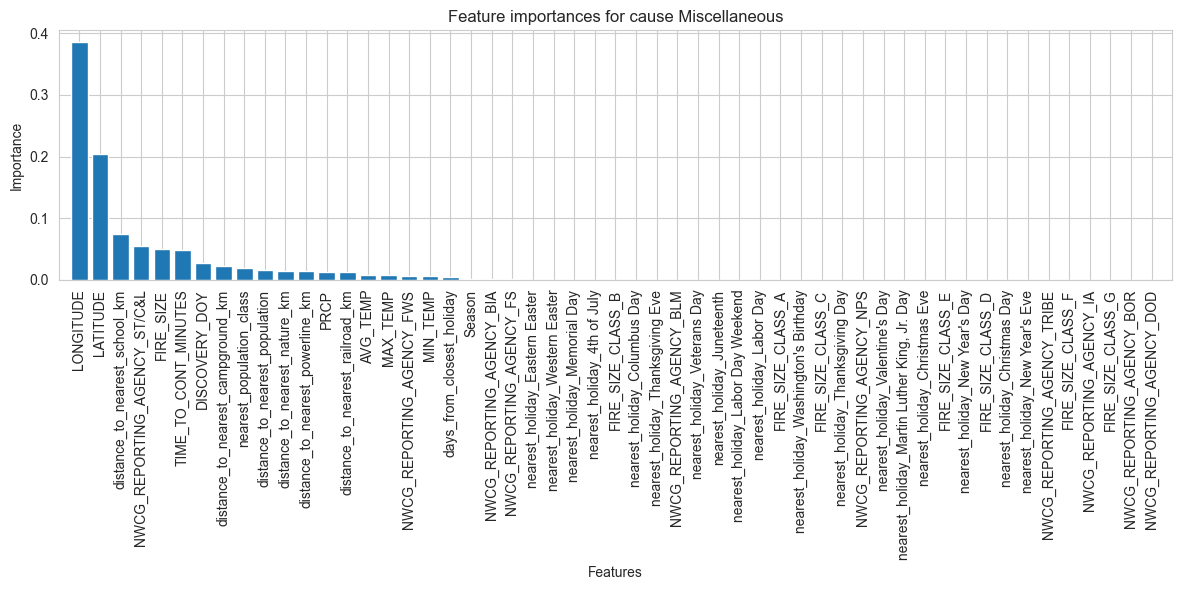

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.0min


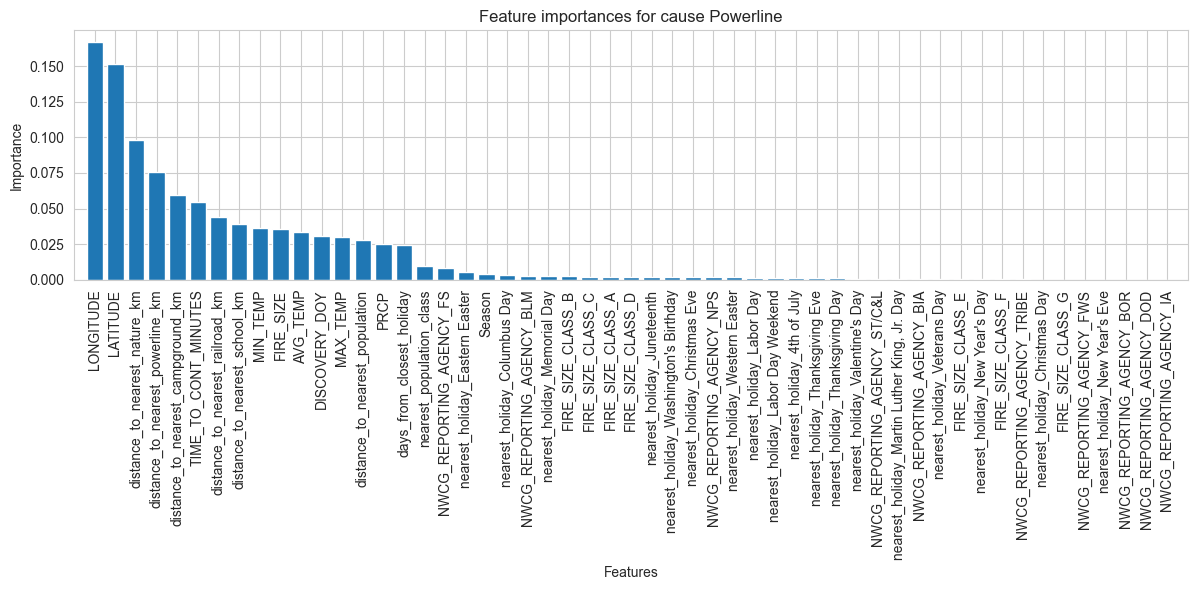

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.1min


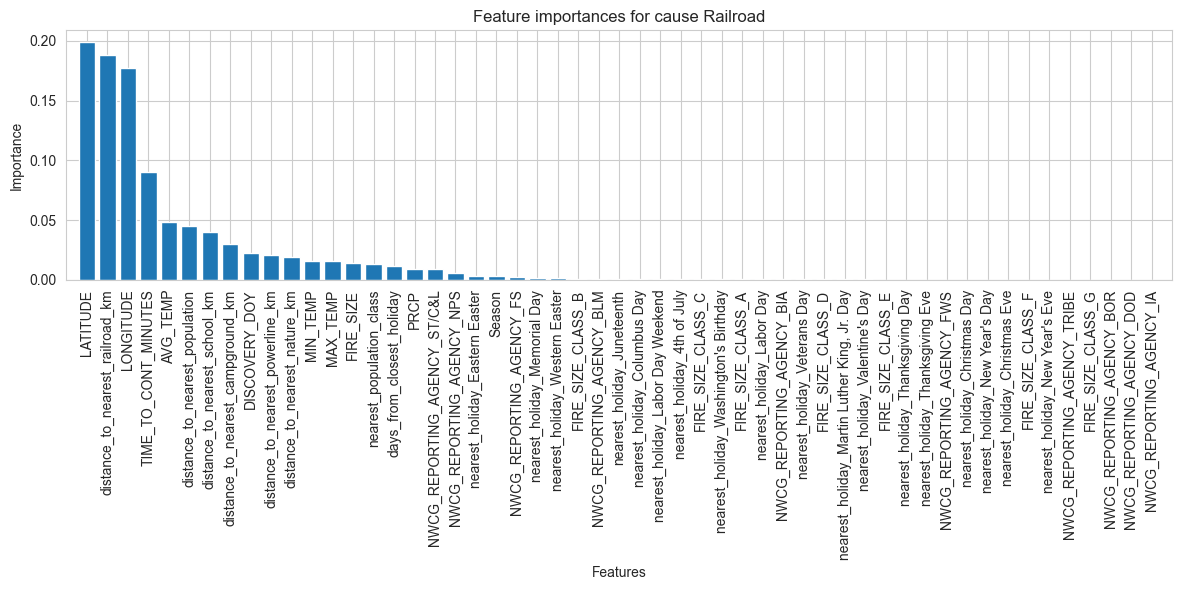

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.4min


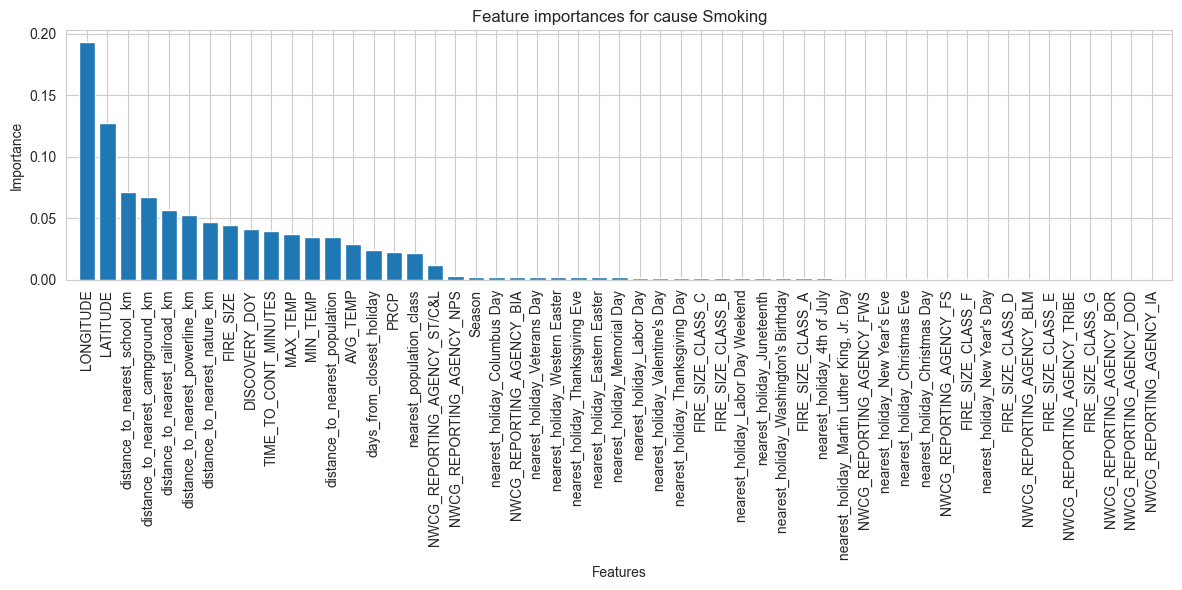

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 12.0min


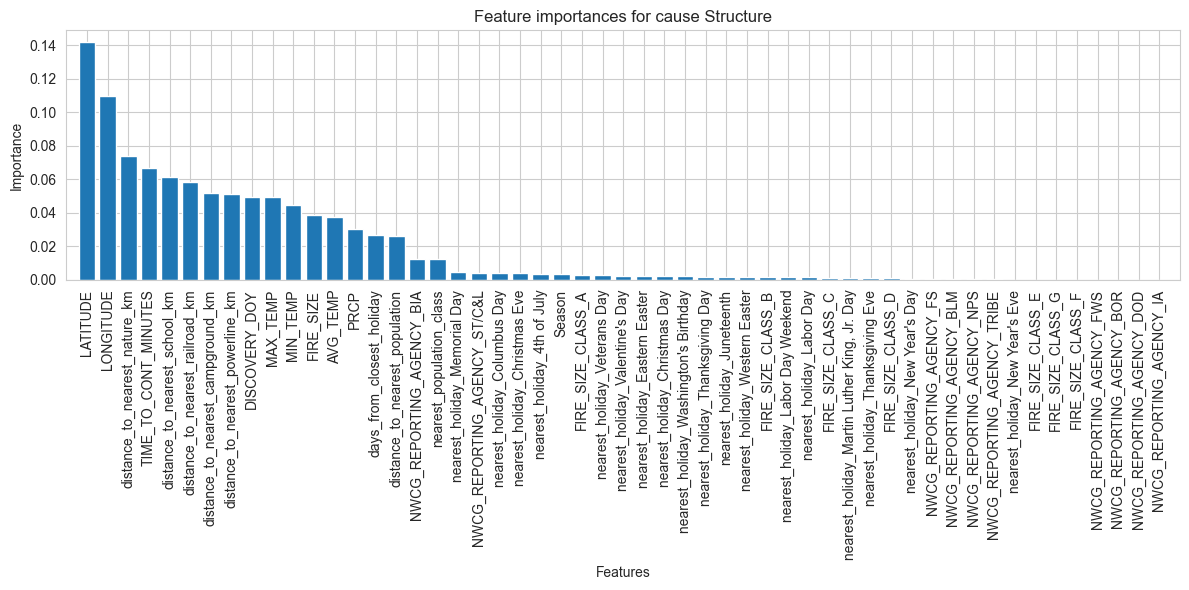

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

for cause,cause_name in mapping_dict.items():
    y_train_binary = (y_train == cause).astype(int)
    
    if better_model_name == 'GBC':
        model = GradientBoostingClassifier(**study.best_params,verbose=1)
    else:
        model = RandomForestClassifier(**study.best_params,verbose=1)
    model.fit(X_train, y_train_binary)

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X_train.columns

    plt.figure(figsize=(12, 6))
    plt.title(f"Feature importances for cause {cause_name}")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()


Next, we will try training better model without the distance related features and check the impact on the model's performance (because they might be highly correlated with LONGITUDE and LATITUDE and therefore not adding much information to the model).

To evaluate the performance we will use cross-validation calculating the ROC AUC score.

In [77]:
cause_mapping = {0: 'Arson', 1: 'Campfire', 2: 'Children', 3: 'Debris Burning', 4: 'Equipment Use', 5: 'Fireworks', 6: 'Lightning', 7: 'Miscellaneous', 8: 'Powerline', 9: 'Railroad', 10: 'Smoking', 11: 'Structure'}

X_train_no_distance = X_train.drop(columns=X_train.columns[X_train.columns.str.startswith('distance_to')])
X_train_no_distance = X_train_no_distance.drop(columns=['nearest_population_class'])
better_model.fit(X_train_no_distance, y_train)

X_test_no_distance = X_test.drop(columns=X_test.columns[X_test.columns.str.startswith('distance_to')])
X_test_no_distance = X_test_no_distance.drop(columns=['nearest_population_class'])

cv_scores_no_distance = cross_val_score(better_model, X_train_no_distance, y_train, cv=5, scoring='roc_auc_ovr')
print(f"Cross-Validation ROC AUC scores without distance related features: {cv_scores_no_distance}")

better_model_predictions_no_distance = better_model.predict(X_test_no_distance)
print(classification_report(y_test, better_model_predictions_no_distance, target_names=list(cause_mapping.values())))

Cross-Validation ROC AUC scores without distance related features: [0.800167   0.80306194 0.80273007 0.80429206 0.80569256]
                precision    recall  f1-score   support

         Arson       0.46      0.31      0.37     18506
      Campfire       0.49      0.24      0.32      5067
      Children       0.31      0.07      0.11      4095
Debris Burning       0.44      0.76      0.56     28523
 Equipment Use       0.40      0.13      0.20      9984
     Fireworks       0.50      0.39      0.44       781
     Lightning       0.71      0.81      0.75     18573
 Miscellaneous       0.45      0.45      0.45     21742
     Powerline       0.00      0.00      0.00       974
      Railroad       0.30      0.27      0.28      2230
       Smoking       0.50      0.00      0.00      3568
     Structure       0.00      0.00      0.00       242

      accuracy                           0.49    114285
     macro avg       0.38      0.29      0.29    114285
  weighted avg       0.48      0.4

/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

At last, we will use isolation forest to detect outliers in the data and remove them to see if it improves the model's performance of the original model.

In [80]:
from sklearn.ensemble import IsolationForest

outlier_detector = IsolationForest(contamination=0.05, random_state=42)
outlier_detector.fit(X_train)

outliers = outlier_detector.predict(X_train) == -1
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

better_model.fit(X_train_no_outliers, y_train_no_outliers)

better_model_predictions_no_outliers = better_model.predict_proba(X_test)
roc_auc_no_outliers = roc_auc_score(y_test, better_model_predictions_no_outliers, multi_class='ovr')
print(f"ROC AUC score without outliers: {roc_auc_no_outliers:.2f}")

better_model_predictions_no_outliers = better_model.predict(X_test)
print(classification_report(y_test, better_model_predictions_no_outliers, target_names=list(cause_mapping.values())))

ROC AUC score without outliers: 0.81
                precision    recall  f1-score   support

         Arson       0.48      0.29      0.36     18506
      Campfire       0.47      0.23      0.30      5067
      Children       0.34      0.10      0.15      4095
Debris Burning       0.43      0.78      0.56     28523
 Equipment Use       0.40      0.13      0.19      9984
     Fireworks       0.56      0.37      0.45       781
     Lightning       0.72      0.81      0.76     18573
 Miscellaneous       0.45      0.45      0.45     21742
     Powerline       0.00      0.00      0.00       974
      Railroad       0.32      0.27      0.29      2230
       Smoking       0.50      0.00      0.00      3568
     Structure       0.00      0.00      0.00       242

      accuracy                           0.49    114285
     macro avg       0.39      0.28      0.29    114285
  weighted avg       0.48      0.49      0.45    114285


/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier